In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import sklearn
from sklearn.datasets import *
import sklearn.linear_model

## Creating the dataset and preprocessing it

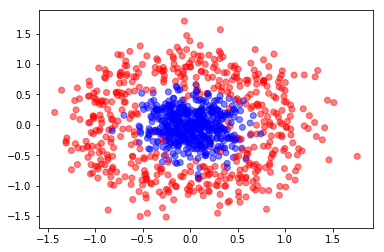

In [3]:
# creating a labelled dataset which will be difficult to classify using linear classifiers like logistic regression

dataset = make_circles(n_samples=1000, shuffle=True, noise=0.25, random_state=2, factor=0.1)
data, labels = dataset[0], dataset[1]
colors = ['red', 'blue']
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = matplotlib.colors.ListedColormap(colors), alpha=0.5)
plt.show()

In [4]:
# shapes of input files

# we need to check whether the inputs are in proper shape. if not, we need to reshape them.

shape_x = data.shape
shape_y = labels.shape

print "shape_X: ", shape_x
print "shape_Y: ", shape_y

shape_X:  (1000, 2)
shape_Y:  (1000,)


In [5]:
# need to reshape the inputs to have shape (num. features X num. observations)
# this is needed to make sure that all the dimensions are in order. this will be very important when defining the weight matrices

data = data.T
labels = labels.reshape(1, len(labels))

shape_x = data.shape
shape_y = labels.shape

print "shape_X: ", shape_x
print "shape_Y: ", shape_y

X = data
Y = labels

shape_X:  (2, 1000)
shape_Y:  (1, 1000)


## Checking the performance of a simple logistic regression classifier

In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/home/krishanu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 50 % (percentage of correctly labelled datapoints)


### So the performance of the logistic regression classifier is not good. We need some way to capture the inherent non linearity in the structure of the data.

Here is where a simple neural network should perform much better. lets see if it actually does. But before that we need to design a neural network.

## Neural Network Model

### Helper Functions

In [8]:
def layers_sizes(X, Y, hidden):
    n_x = X.shape[0]
    n_h = hidden
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

def initialize_params(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

#### Testing the functions

In [9]:
print initialize_params(3, 4, 1)

{'b2': array([[ 0.]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), 'W1': array([[ 0.00809336,  0.00385351, -0.01509913],
       [-0.00597917, -0.01636634,  0.00366829],
       [ 0.00359733,  0.00083288,  0.01130078],
       [-0.0130838 ,  0.00030208, -0.00522757]]), 'W2': array([[ 0.01459693, -0.00612761,  0.00892601,  0.00908652]])}


In [10]:
print layers_sizes(X, Y, 4)

(2, 4, 1)


### Forward propagation steps

In [29]:
def forward_prop(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1. / (1 + np.exp(-Z2))
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    
    return A2, cache

In [36]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    
    cost = - np.sum(logprobs)
    
    cost = np.squeeze(cost)
    
    return cost

In [37]:
def back_prop(parameters, cache, X, Y):
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = (1. / m) * np.dot(dZ2, A1.T)
    db2 = (1. / m) * np.sum(dZ2, axis = 1, keepdims= True)
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1. / m) * np.dot(dZ1, X.T)
    db1 = (1. / m) * np.sum(dZ1, axis = 1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

In [38]:
def update_params(parameters, grads, learning_rate = 0.1):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [42]:
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000):
    n_x, n_h, n_y = layers_sizes(X, Y, 4)[0], layers_sizes(X, Y, 4)[1], layers_sizes(X, Y, 4)[2]
    
    parameters = initialize_params(n_x, n_h, n_y)
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    for i in range(num_iterations):
        A2, cache = forward_prop(X, parameters)
        
        cost = compute_cost(A2, Y, parameters)
        
        grads = back_prop(parameters, cache, X, Y)
        
        parameters = update_params(parameters, grads, learning_rate)
        
        if i % 1000 == 0:
            print "Cost after ", i, " iterations: ", cost
    print "Final cost  after", num_iterations, " iterations: ", cost
    
    return parameters

In [43]:
def predict(X, parameters):
    A2, cache = forward_prop(X, parameters)
    predictions = np.round(A2)
    
    return predictions

In [45]:
parameters = nn_model(X, Y, n_h = 4, learning_rate=1, num_iterations=100000)

Cost after  0  iterations:  693.147094559
Cost after  1000  iterations:  687.594692165
Cost after  2000  iterations:  145.523012717
Cost after  3000  iterations:  131.464542848
Cost after  4000  iterations:  124.080986847
Cost after  5000  iterations:  122.346604948
Cost after  6000  iterations:  121.812470938
Cost after  7000  iterations:  121.463304669
Cost after  8000  iterations:  127.264759115
Cost after  9000  iterations:  123.554792006
Cost after  10000  iterations:  124.305087055
Cost after  11000  iterations:  124.795071295
Cost after  12000  iterations:  124.856559872
Cost after  13000  iterations:  124.985527459
Cost after  14000  iterations:  125.057009161
Cost after  15000  iterations:  125.108004915
Cost after  16000  iterations:  125.146948943
Cost after  17000  iterations:  125.175999312
Cost after  18000  iterations:  125.197528559
Cost after  19000  iterations:  125.213530188
Cost after  20000  iterations:  125.225468583
Cost after  21000  iterations:  125.234400687
C

In [46]:
predictions = predict(X, parameters)

print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')


Accuracy: 95%


## So we see that using a very simple neural network, we can improve the prediction accuracy on the training data by a huge amount (50% to 95%).

### thus we demonstrate the usefulness and implementation of a simple neural network using numpy